# Making tissue annotations with holes in

Starting with a file of tissue annotations, this script will work out which fall within each other (child/parent) and create new polygons encoding holes within them from these annotations

### Load modules

In [33]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import geopandas
from scipy.ndimage import binary_erosion
from skimage.measure import approximate_polygon, find_contours
import shapely
import imantics
import pandas as pd
from geojson import dump 



### Set annotations file path

In [3]:
original_annotation="P:/Bec DT/QuPath/315_89_MSC Panel and Hormone Panel_SerialStainFuse_2024501051inc tissue.geojson"

In [9]:
# Open the anotations file
g_df=geopandas.read_file(original_annotation)

#Extract the classification names to a new col
classifications_original=g_df["classification"]
g_df["names"]=[obj["name"] for obj in classifications_original] #extract annotation names

print("Annotation names are:")
print(set(g_df["names"]))

Annotation names are:
{'ICI', 'Acinar+Islets_inside mapped tissue', 'IDI'}


## Specify name of tissue annotations

In [11]:
tissue_annotation_name='Acinar+Islets_inside mapped tissue'

In [13]:
## Function to make all the annotations into polygons from linestrings. Putting these into a new column in the df and outputting this
# Shapes need to be in this format to have holes within them. The format typically coming from Halo is Linestring rather than Polygon

def add_poly_col(g_df):

    for i in range(len(g_df)):
        line_coords=shapely.get_coordinates(g_df.iloc[i]["geometry"])#get coordinates of the linestring shape
        g_df.at[i,"poly_shape"]=shapely.Polygon(line_coords)#make the line into a polygon. Save that to a new column for that row in thhe df

    return g_df

In [15]:
# add the polygon columns to the geo dfs
g_df=add_poly_col(g_df)

#Make df of only tissue
Tissue_only=g_df[original_g_df["names"]==tissue_annotation_name].copy()


## Are polygons within other shapes?

In [16]:
# Loop through annotations. If they're within another, add them to a list which can ultimately be made into the holes of a polygon
row_index_list=Tissue_only.index

Tissue_only["status"]="orphan"#make all anotations orphas to begin with, then assign parent child status as processed. 
processed_tissue=pd.DataFrame(columns=Tissue_only.columns)#new df for the processed annotations

for row_num in row_index_list:

    row = Tissue_only.loc[row_num].copy() # pull out the row
    contained_mask=Tissue_only.loc[row_num,"poly_shape"].contains(Tissue_only["poly_shape"]) # get mask for df of all the tissue annotations within this annotation
    contained_mask.at[row_num] = False # remove self from the match list
    tissue_holes=Tissue_only[contained_mask]["poly_shape"].tolist() # make a list of the polygons of the annotations
    Tissue_only.loc[contained_mask,"status"]="child"

    if (len(tissue_holes)>0): # If some anotations are found within the annotation being checked then do this

        Tissue_only.loc[row_num,"status"]="parent" # change status 

        shell_coords=shapely.get_coordinates(row["poly_shape"]) # get the coordinates of the annotation in the original row
        holes_coords=[shapely.get_coordinates(i) for i in tissue_holes] # get coordinates of all the annotations contained 
        final_poly=shapely.Polygon(shell = shell_coords, holes=holes_coords) # make a new polygon with holes for the contained annotations

        row["poly_shape"]=final_poly # replace the original annotation polygon with a new one containing holes
        row_df=pd.DataFrame([row])
        processed_tissue=pd.concat([processed_tissue,row_df]) # add to a the new df

        print("Row "+str(row_num) + "contains"+str(contained_mask.sum())) # print a message detailing the holes found


#Add any remaining orphan annotations to the new df with parent polygons
orphan_df=Tissue_only[Tissue_only["status"]=="orphan"]
if len(orphan_df)>0:
    processed_tissue=pd.concat([processed_tissue,orphan_df]) # add to a the new df

# Make the df into a geopandas df
processed_tissue=processed_tissue.drop(columns=["status", "names", "geometry"]).rename(columns={"poly_shape":"geometry"})#remove unnecessary columns and make the polygon_shape column into official "geometry" column
processed_tissue=geopandas.GeoDataFrame(processed_tissue, geometry="geometry")#make geo df



Row 333contains48
Row 337contains60


C:\Users\jcc234\AppData\Local\Temp\ipykernel_96376\2346742913.py:25: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_tissue=pd.concat([processed_tissue,row_df]) # add to a the new df


## Take a look at the difference in the annotations

1. Correctly removed holes will be visible
2. This plots polygons so any shapes overlaying each other will be obscured e.g. shapes within shapes. 
3. Line shapes plotted from original input of tissue annotations. These cannot have holes and are just lines.


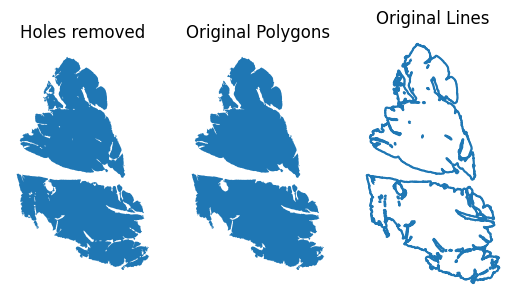

In [31]:
polygons_without_holes=Tissue_only.copy()

polygons_without_holes=geopandas.GeoDataFrame(polygons_without_holes, geometry="poly_shape")

fig, axs = plt.subplots(1,3)

processed_tissue.plot(ax=axs[0])
axs[0].set_title("Holes removed")
axs[0].axis("off")

polygons_without_holes.plot(ax=axs[1])
axs[1].set_title("Original Polygons")
axs[1].axis("off")

Tissue_only.plot(ax=axs[2])
axs[2].set_title("Original Lines")
axs[2].axis("off")

plt.show()

## Save the new annotations file

NB. This also adds the other annotations in the original file back in before saving


In [46]:
##Add other annotations back to the processed tissue
non_tissue_df=g_df[g_df["names"]!=tissue_annotation_name].copy() # copy the non-tissue annotations from original file
non_tissue_df=non_tissue_df.drop(columns=["names", "poly_shape"]) # remove unnecessary columns which have been added during processing
re_joined_processed_df=pd.concat([processed_tissue,non_tissue_df]) # join the processed tissue annotations and the other original annotations 
re_joined_processed_df=re_joined_processed_df.reset_index() #rester the indexing of rows
geo_df_processed_for_saving=geopandas.GeoDataFrame(re_joined_processed_df, geometry="geometry")# make joined df into a geo-df


## Saving
# Set the location of the geojson annotation file to be used (NB. new files will be saved to the same location with modified names)
annotation_file_write_path = original_annotation.replace(".geojson", "_TissueWithHoles.geojson")

with open(annotation_file_write_path, 'w') as f:
   dump(geo_df_processed_for_saving, f)


C:\Users\jcc234\AppData\Local\Temp\ipykernel_96376\2512565605.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  re_joined_processed_df=pd.concat([processed_tissue,non_tissue_df]) # join the processed tissue annotations and the other original annotations
c:\Users\jcc234\AppData\Local\anaconda3\lib\site-packages\geopandas\array.py:1470: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
